# **CNN**

## p5

## *Importing Libraries*

In [237]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(suppress = True)

### *preprocessing data*

In [238]:
# Data

with open('./Data/p4.csv', 'r') as f:
    results = []
    next(f)
    for line in f:
        words = line.split(',')
        for i in range(len(words)):
            words[i] = float(words[i])
        results.append(words)### *Data preprocessing (extraction, splitting)*

In [239]:
def convert_to_one_hot(y, num_classes):
    y_one_hot = np.zeros((y.shape[0], num_classes))
    y_one_hot[np.arange(y.shape[0]), y] = 1
    return y_one_hot

In [240]:
def preprocess_data(X):
    y = X[:, 0].astype(int)
    x = np.delete(X, 0, axis = 1)
    return x, y

In [241]:
# Splits the data with given percentages

def DataSplit(Data, train_percent, test_percent, val_percent = 0):
    split_list = []
    train_size = int(train_percent * Data.shape[0] / 100)
    val_size = int(val_percent * Data.shape[0] / 100)
    test_size = Data.shape[0] - train_size - val_size
    
    # Train and Test data
    DTrain = np.zeros((train_size, Data.shape[1]))
    DTest = np.zeros((test_size, Data.shape[1]))
    DTrain = Data[0:train_size, :]
    DTest = Data[train_size + val_size: Data.shape[0], :]
    split_list.extend([DTrain, DTest])
    
    # For validataion data
    if val_percent > 0:
        DVal = np.zeros((val_size, Data.shape[1]))
        DVal = Data[train_size: train_size + val_size, :]
        split_list.append(DVal)
    return split_list

In [242]:
Data = np.array(results)
labels = np.unique(Data[:,0].astype(int))
input_features = Data.shape[1] - 1

In [243]:
print(Data.shape)
print(input_features)

(60000, 785)
784


In [244]:
split_data = DataSplit(Data, 20, 80)
### *Config - 1 (1 Hidden Layer with 350 neurons)*
# Train and Test Data
DTrain = split_data[0]
DTest = split_data[1]
# Validataion Data
if len(split_data) == 3:
    DVal = split_data[2]

In [245]:
print(DTrain.shape)
print(DTest.shape)

(12000, 785)
(48000, 785)


### *Activations*

In [256]:
class Activation_ReLU:
    # Forward pass
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.maximum(0, inputs)
        return self.output
    def backward(self):
        # Here not necessasry to copy the values as we are only using dvalues once
        self.dinputs = np.ones_like(self.inputs)
        # When the inputs to relu are not positve, make the dinputs zero
        self.dinputs[self.inputs <= 0] = 0
        return self.dinputs

In [257]:
class Activation_Softmax:
    # Forward pass
    def forward(self, inputs):
        exp_values = np.exp(inputs - np.max(inputs, axis = 1, keepdims = True))
        probabilities = exp_values / np.sum(exp_values, axis = 1, keepdims = True)
        self.output = probabilities
        return self.output
    def backward(self, dvalues):
        # Create uninitialized array
        self.dinputs = np.empty_like(dvalues)
        # Enumerate outputs and gradients
        for index, (single_output, single_dvalues) in enumerate(zip(self.output, dvalues)):
            # Flatten output array
            single_output = single_output.reshape(-1, 1)
            # Calculate Jacobian matrix of the output
            jacobian_matrix = np.diagflat(single_output) - np.dot(single_output, single_output.T)
            # Calculate sample-wise gradient
            # and add it to the array of sample gradients
            self.dinputs[index] = np.dot(jacobian_matrix, single_dvalues)
        return self.dinputs
    def predictions(self, outputs):
        return np.argmax(outputs, axis = 1)

### *Optimizer*

In [258]:
class Optimizer_SGD: 
    def __init__(self, learning_rate = 1, decay = 0):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0 
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate / (1 + self.decay * self.iterations)
    def update_params(self, layer):
        if isinstance(layer, Layer_Convolution):
            layer.kernel_weights += -self.current_learning_rate * layer.dweights
        if isinstance(layer, Layer_FullyConnected):
            layer.weights += -self.current_learning_rate * layer.dweights
            layer.biases += -self.current_learning_rate * layer.dbiases   
    def post_update_params(self):
        self.iterations += 1

### *CrossEntropy Loss with Softmax layer*

In [259]:
class Softmax_CrossEntropyLoss:

    def forward(self, y_pred, y_true, classes):
        
        # y_pred shape: (batch_size, num_classes)
        # y_true shape: (batch_size,)
        batch_size = y_pred.shape[0]
        # Clip y_pred values to prevent log(0) errors
        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
        # Compute the log of predicted probabilities for the true class for each example
        log_likelihoods = -np.log(y_pred[range(batch_size), y_true])
        # Compute the mean of the log likelihoods for the batch
        loss = np.mean(log_likelihoods)
        return loss
    
    def backward(self, dvalues, y_true, classes):
          # Number of samples
        samples = len(dvalues)
        # Copy so we can safely modify
        self.dinputs = dvalues.copy()
        # Calculate gradient
        self.dinputs[range(samples), y_true] -= 1
        # Normalize gradient
        self.dinputs = self.dinputs / samples
        return self.dinputs

### *Input Layer*

In [255]:
class Layer_ConvInput:
    def forward(self, X):
        self.output = X
        return self.output

### *Fully Connected Layer*

In [254]:
### *Fully Connected Layer*

class Layer_FullyConnected:
    # Layer Initialization
    def __init__(self, n_inputs, n_neurons):
        
        #Initialize weights and biases
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))   

    def forward(self, inputs):
        
        # calculate the values of the neurons before activation
        # inputs matrix contains features for a sample of data
        self.inputs = inputs
        self.output = np.dot(self.inputs, self.weights) + self.biases
        return self.output
    
    def backward(self, dvalues):
        
        # dvalues are the upstream gradients
        # dweights, dbiases are the backprop gradients with shape similar to weights matrix and bias vector
        # dinputs are the dvalues for the previous layer with shape similar to inputs
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis = 0, keepdims = True)
        self.dinputs = np.dot(dvalues, self.weights.T)
        return self.dinputs

### *Convolution Layer*

In [260]:
class Layer_Convolution:
    
    def __init__(self, kernel_num, kernel_size, input_channels):
        
        self.kernel_num = kernel_num
        self.kernel_size = kernel_size
        self.input_channels = input_channels
        self.kernel_weights = np.random.randn(kernel_num, kernel_size, kernel_size, input_channels) / (kernel_size**2)
    
    def patch_generator(self, inputs):
        
        self.inputs = inputs
        batch_size, height, width, channels = inputs.shape
        for b in range(batch_size):
            for h in range(height - self.kernel_size + 1):
                for w in range(width - self.kernel_size + 1):
                    patch = self.inputs[b, h:(h + self.kernel_size), w:(w + self.kernel_size), :]
                    yield patch, b, h, w
    
    def forward(self, inputs):
        
        batch_size, height, width, channels = inputs.shape
        self.layer_output = np.zeros((batch_size, height - self.kernel_size + 1, width - self.kernel_size + 1, self.kernel_num))
        for patch, b, h, w in self.patch_generator(inputs):
            self.layer_output[b, h, w] = np.sum(patch * self.kernel_weights, axis=(1,2,3))
        return self.layer_output

    def backward(self, dvalues):
        
        self.dinputs = np.zeros(self.inputs.shape)
        self.dweights = np.zeros(self.kernel_weights.shape)
        for patch, b, h, w in self.patch_generator(self.inputs):
            for k in range(self.kernel_num):
                self.dinputs[b, h:h + self.kernel_size, w:w + self.kernel_size, :] += self.kernel_weights[k] * dvalues[b, h, w, k]
                self.dweights[k] += patch * dvalues[b, h, w, k]

        return self.dinputs

### *Max Pooling Layer*

In [264]:
class Layer_Maxpool:
    
    def __init__(self, kernel_size):

        self.kernel_size = kernel_size

    def patch_generator(self, image):

        patch_h = image.shape[1] // self.kernel_size
        patch_w = image.shape[2] // self.kernel_size
        batch_size = image.shape[0]

        for i in range(batch_size):  
            batch_patches = []
            for h in range(patch_h):
                for w in range(patch_w):
                    patch = image[i, (h * self.kernel_size):(h * self.kernel_size + self.kernel_size), (w * self.kernel_size):(w * self.kernel_size + self.kernel_size), :]
                    batch_patches.append(patch)
            yield np.array(batch_patches), i
    
    def forward(self, inputs):
        
        self.inputs = inputs
        batch_size, height, width, channels = self.inputs.shape
        self.layer_output = np.zeros((batch_size, height // self.kernel_size, width // self.kernel_size, channels))
        for batch_patches, i in self.patch_generator(inputs):
            self.layer_output[i] = np.amax(batch_patches, axis = (1,2)).reshape(height // self.kernel_size, width // self.kernel_size, channels)
        return self.layer_output

    def backward(self, dvalues, dvalue_activation):

        dvalues = dvalues.reshape(self.layer_output.shape)
        self.dinputs = np.zeros(self.inputs.shape)
        for batch_patches, i in self.patch_generator(self.inputs):
            batch_size, image_h, image_w, num_channels = batch_patches.shape
            max_val = np.amax(batch_patches, axis=(1,2))

            for h in range(image_h):
                for w in range(image_w):
                    for idx_k in range(num_channels):
                        for b in range(batch_size):
                            if batch_patches[b,h,w,idx_k] == max_val[b,idx_k]:
                                self.dinputs[i, h*self.kernel_size:h*self.kernel_size+self.kernel_size, w*self.kernel_size:w*self.kernel_size+self.kernel_size, idx_k] += dvalues[i, h, w, idx_k] * dvalue_activation[i, h*self.kernel_size:h*self.kernel_size+self.kernel_size, w*self.kernel_size:w*self.kernel_size+self.kernel_size, idx_k]
        return self.dinputs

###  *ConvNet Class*

In [265]:
class ConvNet:
    
    def __init__(self, input_channels, conv_filters, conv_kernel_size, pool_kernel_size, fc_layer_inputs, output_neurons, learning_rate):
        
        # Layers
        self.input_channels = input_channels
        self.hidden_layers = []
        self.loss_fn = Softmax_CrossEntropyLoss()
        self.train_loss = []
        self.optimizer = Optimizer_SGD(learning_rate, decay = 0)
        self.input_layer = Layer_ConvInput()
        for i, conv_filter in enumerate(conv_filters):
            input_channels = input_channels if i == 0 else conv_filters[i - 1]
            conv_layer = Layer_Convolution(conv_filters[i], conv_kernel_size, input_channels)
            pool_layer = Layer_Maxpool(pool_kernel_size)
            activation_layer = Activation_ReLU() 
            self.hidden_layers.extend([conv_layer, pool_layer, activation_layer])
            
        self.output_layer = Layer_FullyConnected(fc_layer_inputs, output_neurons)
        self.output_softmax_layer = Activation_Softmax()

    def forward(self, x):
        x = self.input_layer.forward(x)
        for layer in self.hidden_layers:
            x = layer.forward(x)
        x = x.reshape(x.shape[0], x.shape[1] * x.shape[2] * x.shape[3])
        x = self.output_layer.forward(x)
        x = self.output_softmax_layer.forward(x)
        return x

    def backward(self, y_pred, y_true, classes):
        
         # Compute the derivative of the loss with respect to the output of the model
        
        dL_dy = self.loss_fn.backward(y_pred, y_true, classes)
        
         # backpropagate the derivatives through the output layer
            
        dL_dx = self.output_layer.backward(dL_dy)
        temp = None
        for layer in reversed(self.hidden_layers):
            if isinstance(layer, Activation_ReLU):
                temp = layer.backward()
            elif isinstance(layer, Layer_Maxpool):
                dL_dx = layer.backward(dL_dx, temp)
            else:
                dL_dx = layer.backward(dL_dx)
    
    def train(self, X, epochs = 1, batch_size = None, val_data = None):
        
        for epoch in range(epochs):
            
            np.random.shuffle(X)
            classes = np.unique(X[:, 0].astype(int))
            epoch_accuracy = 0
            for i in range(0, X.shape[0], batch_size):
                batch = X[i:min(X.shape[0], i + batch_size), :]
                x_batch, y_batch = preprocess_data(batch)
                x_batch = x_batch.reshape(-1, 28, 28, 1)
                # Forward pass
                outputs = self.forward(x_batch)
                
                
                predictions = self.output_softmax_layer.predictions(outputs)

                # Accuracy
                epoch_accuracy += np.count_nonzero(predictions == y_batch)
                
                # Backward pass 
                self.backward(outputs, y_batch, classes)
                    
                for layer in self.hidden_layers:
                    self.optimizer.pre_update_params()
                    self.optimizer.update_params(layer)
                    self.optimizer.post_update_params()
                self.optimizer.update_params(self.output_layer)
            t_loss = self.calculate_loss(X)
            print('Epoch: ', epoch + 1, ' Accuracy: ', round(epoch_accuracy * 100 / len(X), 2), 'Train Loss =', t_loss)
    
    def test(self, X):
        
        test_accuracy = 0
        classes = np.unique(X[:, 0].astype(int))
        x, y = preprocess_data(X)
        x = x.reshape(-1, 28, 28, 1)
        # Forward pass
        outputs = self.forward(x)
        predictions = self.output_softmax_layer.predictions(outputs)
        test_accuracy += np.count_nonzero(predictions == y)
        print('\033[1mTest Accuracy = ', round(test_accuracy * 100 / len(X), 2), '\033[0m')
        print('\n')
        
    def calculate_loss(self, X):
        
        train_data, train_labels = preprocess_data(X)
        classes = np.unique(X[:, 0].astype(int))
        train_data = train_data.reshape(-1, 28, 28, 1)
        outputs = self.forward(train_data)
        loss = self.loss_fn.forward(outputs, train_labels, classes)
        self.train_loss.append(loss)
        return loss
            
    def f1score(self, predicted_labels, test_labels, classes):
    
        # Confusion Matrix

        ConfMatrix = np.zeros([classes, classes])

        for i in range(len(test_labels)):
            ConfMatrix[test_labels[i], predicted_labels[i]] += 1

        # Precision

        Precision = []
        for i in range(classes):
            Precision.append(ConfMatrix[i][i] / np.sum(ConfMatrix[:,i]))

        # Recall

        Recall = []
        for i in range(classes):
            Recall.append(ConfMatrix[i][i] / np.sum(ConfMatrix[i,:]))

        # f1 Score

        f1Score = []
        for i in range(classes):
            f1Score.append(2 * Recall[i] * Precision[i] / (Recall[i] + Precision[i]))
            print('f1 Score of Class ', i , ' is: ', f1Score[i])
    

In [270]:
def plot_loss(train_loss_list):
    # define the lists to plot
    plt.plot(train_loss_list[0], label = 'model 1')
    plt.plot(train_loss_list[1], label = 'model 2')
    plt.plot(train_loss_list[2], label = 'model 3')

    # add labels and legend
    plt.xlabel('Epoch')
    plt.ylabel('Train Loss')
    plt.title('Train Loss vs Epochs')
    plt.legend()

    # show the plot
    plt.show()

In [271]:
loss_list = []

### *Config - 1 (1 Conv layer with depth = 1 and kernel size 3 x 3)*

In [267]:
input_channels = 1
conv_filters = [1]
conv_kernal_size = 3
pool_kernal_size = 2
fc_layer_inputs = 13 * 13 * 1
output_neurons = 10
epochs = 10
batch_size = 256
learning_rate = 0.001

model = ConvNet(input_channels, conv_filters, conv_kernal_size, pool_kernal_size, fc_layer_inputs, output_neurons, learning_rate)

In [268]:
model.train(DTrain, epochs, batch_size)

Epoch:  1  Accuracy:  56.35 Train Loss = 0.8629731290579751
Epoch:  2  Accuracy:  83.98 Train Loss = 0.5832502417487061
Epoch:  3  Accuracy:  87.41 Train Loss = 0.47097778053098227
Epoch:  4  Accuracy:  88.92 Train Loss = 0.4114188389919482
Epoch:  5  Accuracy:  90.0 Train Loss = 0.372636982821664
Epoch:  6  Accuracy:  90.68 Train Loss = 0.3448292871619609
Epoch:  7  Accuracy:  91.21 Train Loss = 0.323949451445655
Epoch:  8  Accuracy:  91.71 Train Loss = 0.3076545147906164
Epoch:  9  Accuracy:  92.02 Train Loss = 0.2945701182537175
Epoch:  10  Accuracy:  92.27 Train Loss = 0.2841559436144243


In [272]:
model.test(DTest)

Test Accuracy =  88.92 




In [273]:
loss_list.append(model.train_loss)

### *Config - 2 (1 Conv layer with depth = 1 and kernel size 5 x5)*

In [277]:
input_channels = 1
conv_filters = [1]
conv_kernal_size = 5
pool_kernal_size = 2
fc_layer_inputs = 12 * 12 * 1
output_neurons = 10
epochs = 10
batch_size = 256
learning_rate = 0.0005

model = ConvNet(input_channels, conv_filters, conv_kernal_size, pool_kernal_size, fc_layer_inputs, output_neurons, learning_rate)

In [278]:
model.train(DTrain, epochs, batch_size)

Epoch:  1  Accuracy:  67.14 Train Loss = 0.4790577779919649
Epoch:  2  Accuracy:  88.55 Train Loss = 0.3183419281368177
Epoch:  3  Accuracy:  90.96 Train Loss = 0.2682759758840193
Epoch:  4  Accuracy:  92.43 Train Loss = 0.21862942443928435
Epoch:  5  Accuracy:  93.45 Train Loss = 0.21209975210104715
Epoch:  6  Accuracy:  94.08 Train Loss = 0.17314044720866809
Epoch:  7  Accuracy:  94.53 Train Loss = 0.16285471139790214
Epoch:  8  Accuracy:  94.45 Train Loss = 0.17363101466490607
Epoch:  9  Accuracy:  95.08 Train Loss = 0.17215373536169906
Epoch:  10  Accuracy:  95.13 Train Loss = 0.16812537776881645


In [279]:
model.test(DTest)

Test Accuracy =  91.4 




In [280]:
loss_list.append(model.train_loss)

### *Config - 3 (2 Conv layers with depths = 2 & 3 and kernel size 3 x3)*

In [281]:
input_channels = 1
conv_filters = [2, 3]
conv_kernal_size = 3
pool_kernal_size = 2
fc_layer_inputs = 5 * 5 * 3
output_neurons = 10
epochs = 10
batch_size = 256
learning_rate = 0.001

model = ConvNet(input_channels, conv_filters, conv_kernal_size, pool_kernal_size, fc_layer_inputs, output_neurons, learning_rate)

In [282]:
model.train(DTrain, epochs, batch_size)

Epoch:  1  Accuracy:  56.85 Train Loss = 0.6073283220274707
Epoch:  2  Accuracy:  85.37 Train Loss = 0.36637930149056197
Epoch:  3  Accuracy:  89.87 Train Loss = 0.31723788959128457
Epoch:  4  Accuracy:  90.68 Train Loss = 0.30467983985960584
Epoch:  5  Accuracy:  91.22 Train Loss = 0.2696943504669103
Epoch:  6  Accuracy:  91.97 Train Loss = 0.28043703026778816
Epoch:  7  Accuracy:  92.22 Train Loss = 0.2985425278133744
Epoch:  8  Accuracy:  92.55 Train Loss = 0.24504004084149508
Epoch:  9  Accuracy:  92.59 Train Loss = 0.237478726305382
Epoch:  10  Accuracy:  92.58 Train Loss = 0.23098710749771134


In [283]:
model.test(DTest)

Test Accuracy =  90.15 




In [284]:
loss_list.append(model.train_loss)

### *Plot*

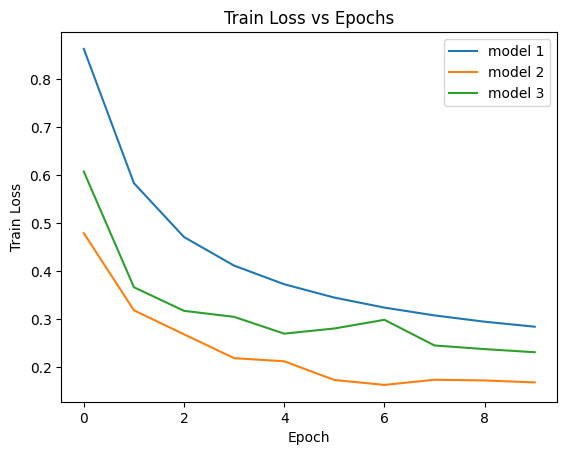

In [288]:
plot_loss(loss_list)